In [1]:
# imports

import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ncistd import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [3]:
# look at data

data_dir = Path('../../data/fitting-test/pro/')
results_df = pd.read_csv(data_dir / 'cv_data.csv')

# add features
results_df['comparison'] = (results_df['modeled_replicate'] == results_df['comparison_replicate']).map({
    True: 'fitting', False: 'cross-validation'
})
results_df['sparsity coefficient'] = results_df['lambda'].astype(str)

results_df


,bootstrap_id,rank,lambda,modeled_replicate,comparison_replicate,replicate_pair,n_components,mean_gene_sparsity,relative_sse,fms_cv,css_cv_factor0,scss_cv_factor0,comparison,sparsity coefficient
0,0,1,0.0,A,A,"A, A",1,5084.0,0.814638,NaN,NaN,NaN,fitting,0.0
1,0,1,0.0,A,B,"A, B",1,5084.0,1.300109,0.004075,0.812575,1.0,cross-validation,0.0
2,0,1,0.0,A,C,"A, C",1,5084.0,1.141519,0.151893,0.829107,1.0,cross-validation,0.0
3,0,1,0.0,B,A,"B, A",1,5084.0,1.130204,NaN,NaN,NaN,cross-validation,0.0
4,0,1,0.0,B,B,"B, B",1,5084.0,0.881934,NaN,NaN,NaN,fitting,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0,50,100.0,B,B,"B, B",0,0.0,1.000000,NaN,NaN,NaN,fitting,100.0
266,0,50,100.0,B,C,"B, C",0,0.0,1.000000,0.000000,0.000000,0.0,cross-validation,100.0
267,0,50,100.0,C,A,"C, A",0,0.0,1.000000,NaN,NaN,NaN,cross-validation,100.0
268,0,50,100.0,C,B,"C, B",0,0.0,1.000000,NaN,NaN,NaN,cross-validation,100.0


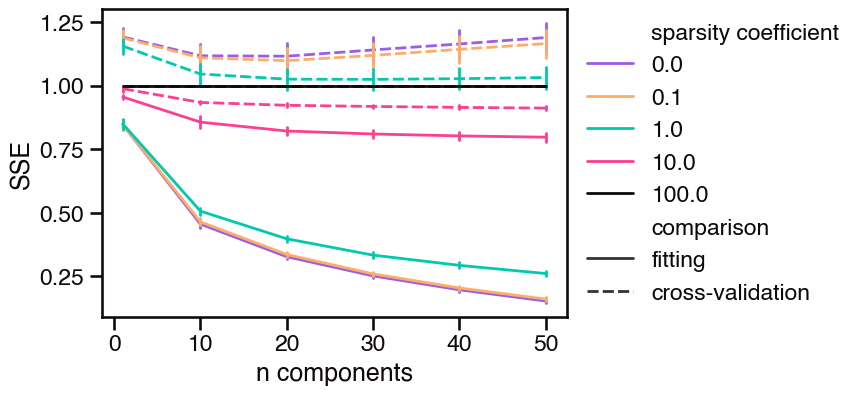

In [4]:
# look at relative_sse vs rank

# define data
plot_df = results_df.copy()

# plot figure
fig, axis = plt.subplots(figsize=(6, 4))
# for i, lamb in enumerate(plot_df['lambda'].unique()):
#     data_df = plot_df[plot_df['lambda'] == lamb]
sns.lineplot(
    x='rank', 
    y='relative_sse', 
    hue='sparsity coefficient', 
    style='comparison', 
    errorbar='se', 
    err_style='bars', 
    data=plot_df,
    ax=axis, 
#     label=lamb, 
);

# plt.xlim([0.6, 12.4])
plt.xlabel('n components');
plt.ylabel('SSE')
plt.legend(loc='center left', bbox_to_anchor=[1, 0.5]);
plt.savefig('syn-sse-v-rank-batch-norm.png', bbox_inches='tight')


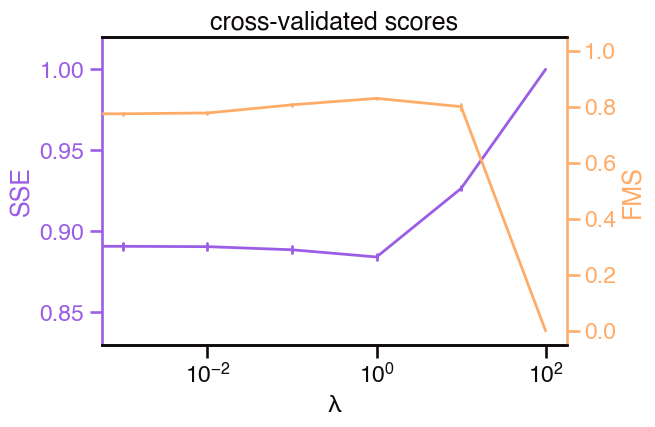

In [206]:
# look at SSE and FMS vs lambda

# define data
plot_df = sim_df[sim_df['modeled_replicate'] != sim_df['comparison_replicate']]
plot_df = plot_df[plot_df['rank'] == plot_df['simulation_rank']]

# plot SSE
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
color = sns.color_palette()[0]
fig, axis = plt.subplots(figsize=(6, 4))
sns.lineplot(
    x='lambda', 
    y='relative_sse', 
    color=color, 
    errorbar='se', 
    err_style='bars',
    data=plot_df, 
    ax=axis, 
    legend=False
)
axis.set(ylim=[0.83, 1.02], xlabel='λ', ylabel='SSE')
axis.yaxis.label.set_color(color)
axis.tick_params(axis='y', colors=color)
axis.spines['left'].set_color(color)

# plot FMS
color = sns.color_palette()[1]
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.left'] = False
axis2 = plt.twinx(axis)
sns.lineplot(
    x='lambda', 
    y='model_fms', 
    color=color, 
    errorbar='se', 
    err_style='bars',
    data=plot_df, 
    ax=axis2, 
    legend=False
)
axis2.set(ylim=[-.05, 1.05], xlabel='λ', ylabel='FMS')
axis2.yaxis.label.set_color(color)
axis2.tick_params(axis='y', colors=color)
axis2.spines['right'].set_color(color)

# put defaults back where you found them
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.left'] = True

# fix x axis stuff
plt.xscale('log');
plt.title('cross-validated scores');
plt.savefig('sim{}-cv-scores-v-lambda.png'.format(sim_id), bbox_inches='tight')


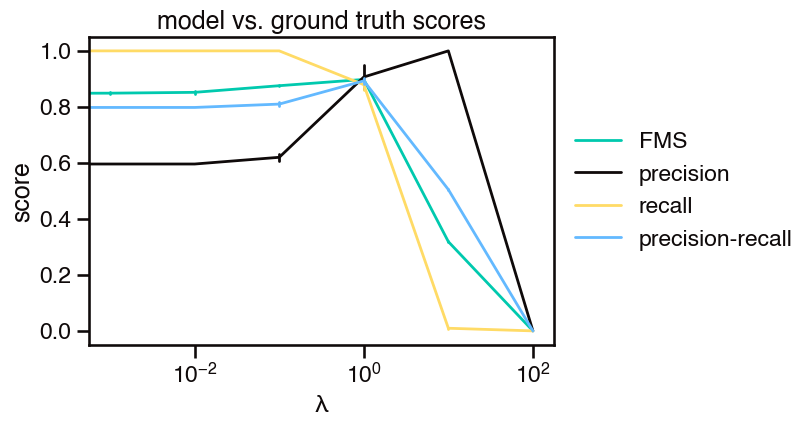

In [207]:
# look at relative_sse vs lambda

plot_df = sim_df[sim_df['modeled_replicate'] == sim_df['comparison_replicate']]
plot_df = plot_df[plot_df['rank'] == plot_df['simulation_rank']]
plot_df['precision-recall'] = (plot_df['precision'] + plot_df['recall']) / 2

fig, axis = plt.subplots(figsize=(6, 4))
for i, var in enumerate(['true_fms', 'precision', 'recall', 'precision-recall']):
    label='FMS' if var == 'true_fms' else var
    sns.lineplot(
        x='lambda', 
        y=var, 
        color=sns.color_palette()[2*(i+1)], 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
        label=label
    );

plt.xscale('log', base=10);
plt.xlabel('λ')
plt.ylabel('score')
plt.legend(loc='center left', bbox_to_anchor=[1, 0.5]);
plt.title('model vs. ground truth scores');
plt.savefig('sim{}-ground-truth-scores-v-lambda.png'.format(sim_id), bbox_inches='tight')


# Look at specific decompositions

{
    "simulation_id": 10,
    "simulation_rank": 6,
    "simulation_shape": "(12, 65, 27)",
    "simulation_densities": "[0.7780447267813538, 0.695508011618681, 0.9176534329949577]",
    "simulation_mean_gene_sparsity": 9.336536721376246,
    "noise_level": 2.4624642297213044
}
	FMS: 0.8466003439134404


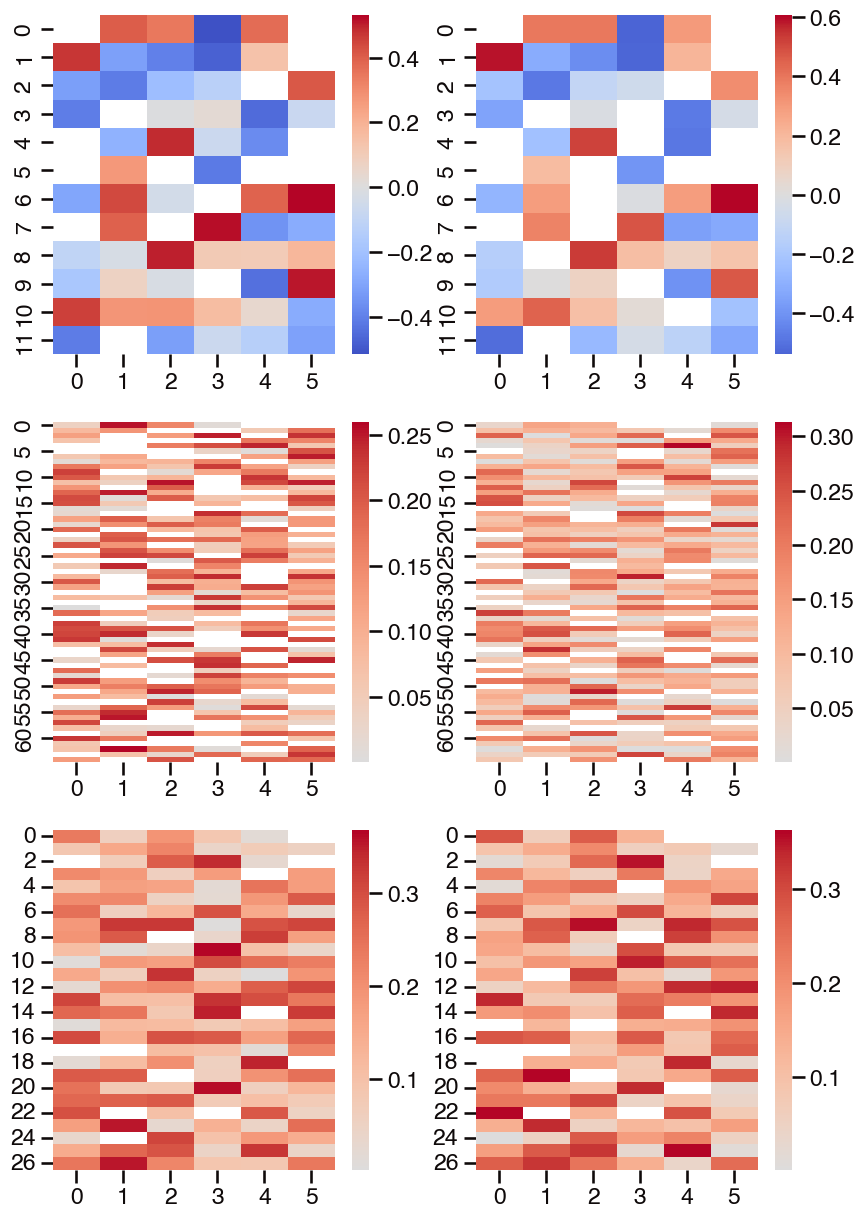

In [204]:
# look at factors of an example decomposition

sim_id = 10
replicate = 'A'
rank = 6
sparsity = 1.

# print simulation information
sim_df = results_df[results_df['simulation_id'] == sim_id]
print(json.dumps(sim_df[[
    'simulation_id', 
    'simulation_rank', 
    'simulation_shape', 
    'simulation_densities', 
    'simulation_mean_gene_sparsity', 
    'noise_level'
]].drop_duplicates().to_dict('records')[0], indent=4))

# build filepaths of true cp and optimal decomposition
true_path = data_dir / 'sim{}'.format(
    sim_id, 
)
decomp_path = data_dir / 'sim{}/replicate{}/rank{}/lambda{}'.format(
    sim_id, 
    replicate, 
    rank, 
    sparsity
)

# load cps
true_cp = load_cp_tensor(true_path / 'simulation_ground_truth.h5')
cp = load_cp_tensor(decomp_path / 'fitted_model.h5')

# calculate fms and get optimal permutation
fms, perm = factor_match_score(true_cp, cp, return_permutation=True, allow_smaller_rank=True)
cp_perm = tlviz.factor_tools.permute_cp_tensor(cp, perm)
print('\tFMS: {}'.format(fms))

# plot
heatmap_params = {'vmin':None, 'vmax':None, 'cmap':'coolwarm', 'center':0}
fig, ax = plot_factors_heatmap(
    tl.cp_normalize(cp_perm).factors, 
    reference_factors=tl.cp_normalize(true_cp).factors, 
    mask_thold=[0, 0], 
    ratios=False, 
    heatmap_kwargs=heatmap_params)
plt.savefig('sim{}-rep{}-factors-r={}-l={}.png'.format(sim_id, replicate, rank, sparsity), bbox_inches='tight')
plt.show()
